In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from hyppo.independence import Dcorr
from lol import LOL
from sklearn.utils import check_X_y
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

from nilearn import datasets, plotting
import nibabel as nib

import sys

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
datadir = Path("/mnt/ssd3/ronan/data")
tag = "_min_rank-ZG3"  #'_max_rank-ZG2'
gccadir = datadir / f"gcca_05-26-10:39{tag}"  # f'gcca_05-17-18:27{tag}' #
dmap_dir = datadir / f"dmap_09-04"

<IPython.core.display.Javascript object>

In [4]:
data = "dmap"

# script code
if data == "gcca":
    flag = "_gcca"
    ftype = "h5"
    source_dir = gccadir
elif data == "dmap":
    flag = "_emb"
    ftype = "npy"
    source_dir = dmap_dir
else:
    raise ValueError(f"{data} invalid data key")
groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=data
)

<IPython.core.display.Javascript object>

In [16]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "Expert",
    "n": "Novice",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
y_labels = [f"{label_transform[a]} {label_transform[b]}" for a, b in y]

<IPython.core.display.Javascript object>

In [11]:
def center_distmat(distx):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]
    exp_distx = (
        np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
        + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
        - distx.sum() / ((n - 1) * (n - 2))
    )
    cent_distx = distx - exp_distx
    np.fill_diagonal(cent_distx, 0)
    return cent_distx

<IPython.core.display.Javascript object>

In [53]:
X = np.vstack(groups)
X = X.reshape(X.shape[0], -1)
X = X[np.argsort(np.concatenate(subjs)), :]
X_dists = pairwise_distances(X, metric="euclidean")

<IPython.core.display.Javascript object>

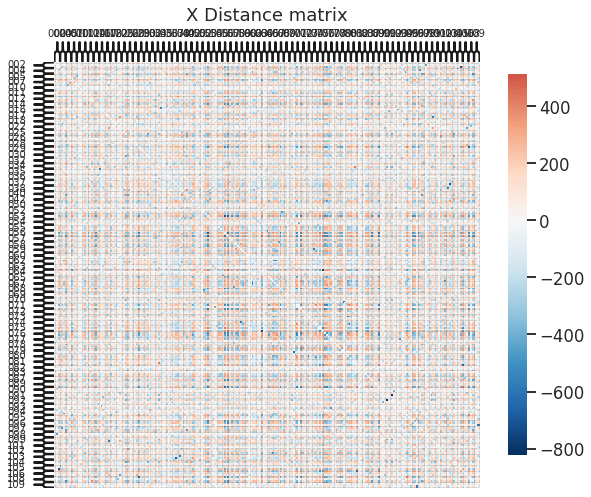

<IPython.core.display.Javascript object>

In [12]:
fig = heatmap(
    center_distmat(X_dists),
    title=f"X Distance matrix",
    transform=None,
    inner_hier_labels=np.concatenate(subjs),
    hier_label_fontsize=10,
)
plt.show()

In [23]:
# RedBu 9
colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#92c5de",
    "#4393c3",
    "#2166ac",
]


def fit_transform(X, y, return_projs=False):
    X, y = check_X_y(
        X, y, dtype=[np.float64, np.float32], ensure_2d=True, copy=True, y_numeric=True
    )

    means = []
    stds = []
    classes = np.unique(y)
    for group in classes:
        Xg = X[y == group, :]
        means.append(Xg.mean(0))
        stds.append(Xg.std(0))

    idx = np.asarray([5, 4, 3, 2, 1, 0])
    delta = np.asarray(means)[idx]

    delta[1:] -= delta[0]

    return X @ delta[1:].T, delta[1:].T, np.asarray(stds).T

<IPython.core.display.Javascript object>

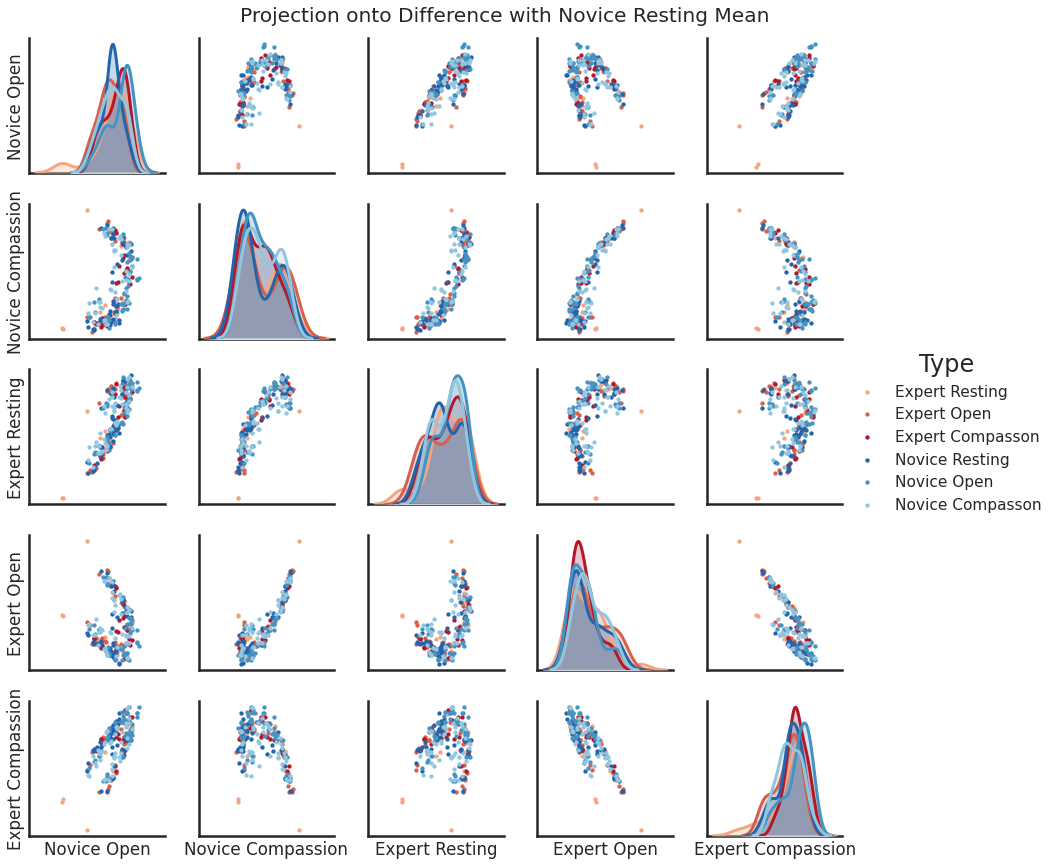

<IPython.core.display.Javascript object>

In [29]:
proj, loadings, stds = fit_transform(X_dists, y_labels)
xticklabels = [
    "Novice Open",
    "Novice Compassion",
    "Expert Resting",
    "Expert Open",
    "Expert Compassion",
]
class_labels = {
    "e restingstate": "Expert Resting",
    "e openmonitoring": "Expert Open",
    "e compassion": "Expert Compassion",
    "n restingstate": "Novice Resting",
    "n openmonitoring": "Novice Open",
    "n compassion": "Novice Compassion",
}
proj_labels = y_labels
pairplot(
    proj,
    proj_labels,
    col_names=xticklabels,
    variables=xticklabels,
    palette={name: col for name, col in zip(np.unique(y_labels), colors)},
    title=f"Projection onto Difference with Novice Resting Mean",
    alpha=1.0,
    size=75,
    context="poster",
    font_scale=0.7,
)
plt.show()

In [47]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()
external_dir = Path("../data/external")


def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed=1,
    title=None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(
        n_embed,
        4,
        subplot_kw={"projection": "3d"},
        figsize=(res_scale * 5, res_scale * n_embed),
    )
    if n_embed == 1:
        axes = [axes]

    plt.subplots_adjust(wspace=0, hspace=0)

    for i, ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / "lh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[: len(cortex_left)]

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu_r",
            axes=ax[0],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu_r",
            view="medial",
            axes=ax[1],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        cortex_right = nib.freesurfer.read_label(external_dir / "rh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left) :]

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=False,
            cmap="RdBu_r",
            axes=ax[2],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=colorbar,
            cmap="RdBu_r",
            view="medial",
            axes=ax[3],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f"{str(save_path)}.png", format="png", bbox_inches="tight")
    else:
        return fig


#         plt.show()
#         plt.close(fig)


def make_cbar(vmax, save_path=None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu_r
    else:
        cmap = mpl.cm.Blues_R
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    # cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")

    # cb1.set_clim(vmin, vmax)
    # cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f"{str(save_path)}.pdf", bbox_inches="tight")
    plt.close(fig)

<IPython.core.display.Javascript object>

In [6]:
SAVE = False
COLORBAR = True
n_embed = 3

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

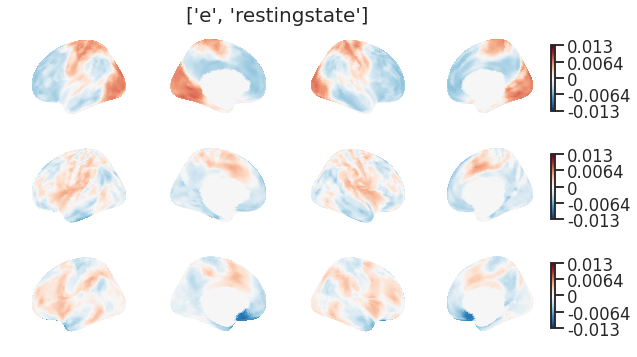

<Figure size 432x288 with 0 Axes>

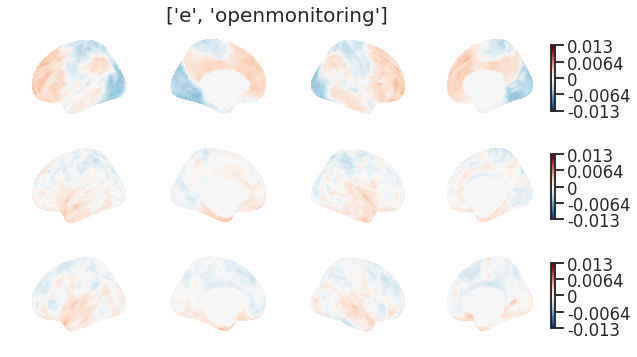

<Figure size 432x288 with 0 Axes>

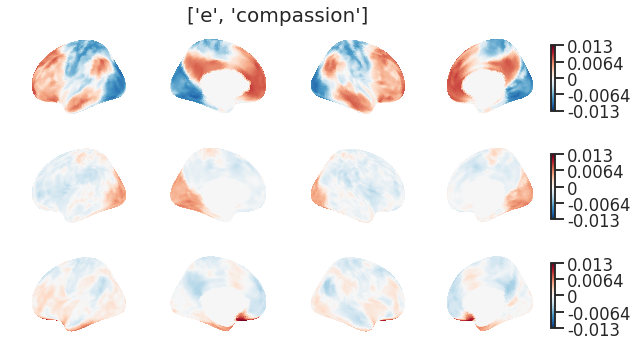

<Figure size 432x288 with 0 Axes>

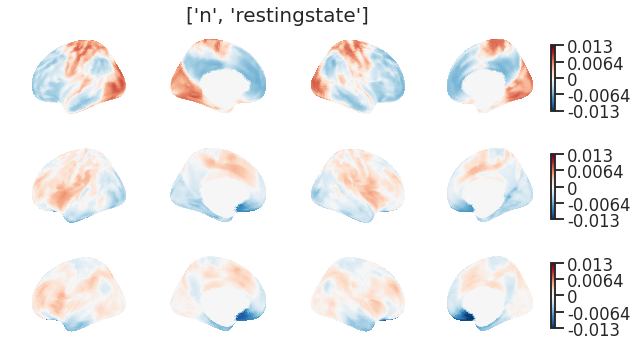

<Figure size 432x288 with 0 Axes>

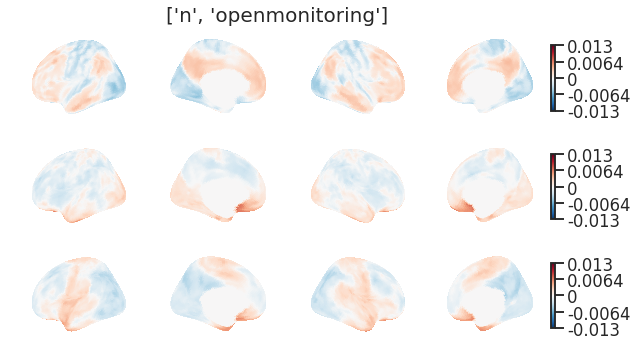

<Figure size 432x288 with 0 Axes>

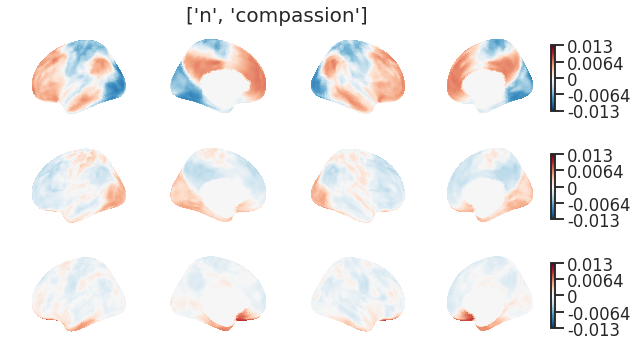

<IPython.core.display.Javascript object>

In [86]:
means = []
for group in groups:
    ## Select Gradient(s)
    X = np.stack(group)
    X = (X / np.linalg.norm(X, axis=1, keepdims=True)).mean(axis=0)
    means.append(X[:, :n_embed])

if COLORBAR:
    vmax = np.max(np.abs(means))

for mean, name in zip(means, labels):
    if SAVE:
        title = False
    else:
        title = f"{name}"
    visualize_embeddings(
        mean,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    plt.show()

<Figure size 432x288 with 0 Axes>

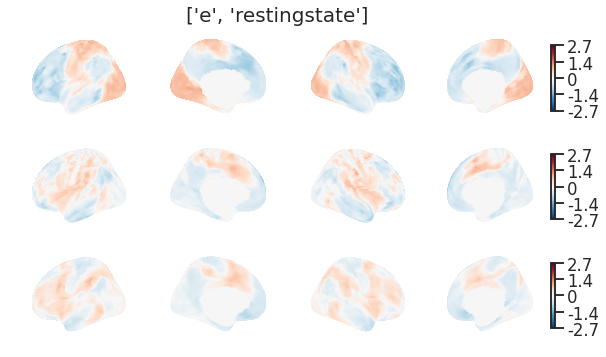

<Figure size 432x288 with 0 Axes>

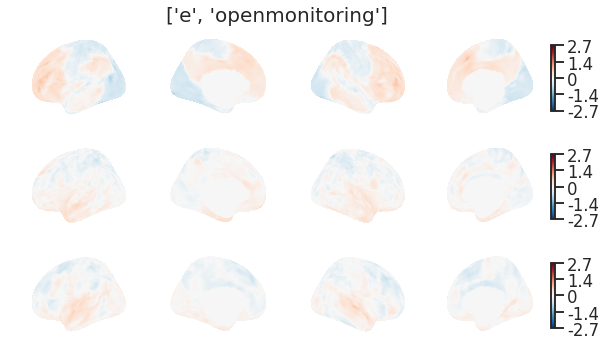

<Figure size 432x288 with 0 Axes>

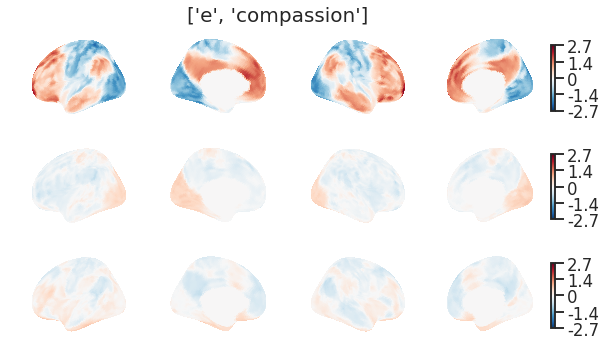

<Figure size 432x288 with 0 Axes>

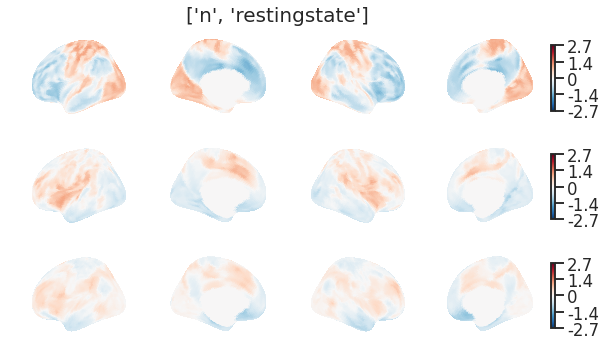

<Figure size 432x288 with 0 Axes>

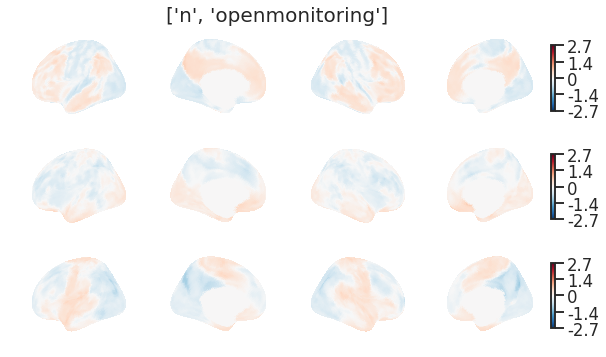

<Figure size 432x288 with 0 Axes>

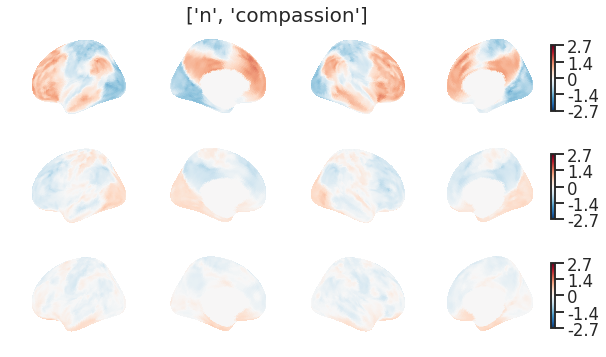

<IPython.core.display.Javascript object>

In [97]:
SAVE = False
COLORBAR = True
n_embed = 3

means = []
for group in groups:
    ## Select Gradient(s)
    X = np.stack(group)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    mu = X.mean(axis=0)
    std = X.std(axis=0, ddof=1)
    means.append((mu / std)[:, :n_embed])

if COLORBAR:
    vmax = np.max(np.abs(means))

for mean, name in zip(means, labels):
    if SAVE:
        title = False
    else:
        title = f"{name}"
    visualize_embeddings(
        mean,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    plt.show()